In [10]:
# 데이터 로딩 + 구조 점검
import os
import pandas as pd

os.chdir("C:/Users/401-09/Desktop/유전자_dl")
df = pd.read_csv("data/AE_input.csv")
print(df.shape)
df.head()

(63, 18632)


,Unnamed: 0,15E1.2,2'-PDE,7A5,A1BG,A2BP1,A2M,A2ML1,A3GALT2,A4GALT,...,ZZZ3,bA16L21.2.1,bA9F11.1,dJ222E13.2,eIF2A,hCAP-D3,hCAP-H2,mimitin,psiTPTE22,raptor
0,3100083_Stroke,0.264796,-0.993720,1.311836,-0.449953,0.299290,-0.171909,-1.386964,-0.109468,-1.538368,...,-1.015975,-1.118698,0.275145,-0.486313,-0.968420,0.948740,0.364261,-0.589495,-0.828620,0.255998
1,3100191_Stroke,-1.655562,-0.920468,1.254974,1.160088,1.969535,-0.333171,1.459663,-0.178682,-0.153262,...,-0.350148,-1.851077,-0.558654,-0.991659,-1.315391,1.297689,-1.655779,-0.008901,-1.672563,-0.278169
2,3100068_Stroke,1.260273,-2.007904,-0.740763,-0.818691,-2.420044,0.232960,1.196944,0.735667,2.950623,...,-1.294807,-1.178315,0.732464,-0.257061,-0.431698,0.236757,-2.598921,-1.866173,1.584548,2.562095
3,3100060_Stroke,-0.555455,-0.955728,-0.744153,2.359199,-0.960852,-0.775154,1.519596,-0.538368,1.599964,...,-0.802067,-1.386907,-0.568032,-0.952378,0.420694,0.380534,-1.411813,-0.187836,-0.205303,0.769656
4,3100138_Stroke,-2.004888,0.202017,0.465204,-0.279563,0.831438,-0.621588,-0.472711,0.389695,-1.247356,...,-0.658673,-0.820424,-1.738871,-1.540441,-2.034253,-0.275462,-1.788697,-2.644954,-0.935344,1.305107


In [11]:
# 1. 이름 분리
df[['sample', 'group']] = df['Unnamed: 0'].str.split('_', expand=True)

# 2. 첫 컬럼 제거
df = df.drop(columns=['Unnamed: 0'])

# 3. 마지막에 컬럼 순서 정리 (선택)
cols = ['sample', 'group'] + [col for col in df.columns if col not in ['sample', 'group']]
df = df[cols]

# 확인
print(df.shape)
df.head(2)

(63, 18633)


,sample,group,15E1.2,2'-PDE,7A5,A1BG,A2BP1,A2M,A2ML1,A3GALT2,...,ZZZ3,bA16L21.2.1,bA9F11.1,dJ222E13.2,eIF2A,hCAP-D3,hCAP-H2,mimitin,psiTPTE22,raptor
0,3100083,Stroke,0.264796,-0.993720,1.311836,-0.449953,0.299290,-0.171909,-1.386964,-0.109468,...,-1.015975,-1.118698,0.275145,-0.486313,-0.968420,0.948740,0.364261,-0.589495,-0.828620,0.255998
1,3100191,Stroke,-1.655562,-0.920468,1.254974,1.160088,1.969535,-0.333171,1.459663,-0.178682,...,-0.350148,-1.851077,-0.558654,-0.991659,-1.315391,1.297689,-1.655779,-0.008901,-1.672563,-0.278169


In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 피처 추출
X = df.drop(columns=['sample', 'group'])

# log1p 하기 전에 값 클리닝
X[X <= -1] = np.nan
X = X.fillna(0)  # 또는 mean/median 등으로 대체 가능
# log1p 변환
X_log = np.log1p(X)

# 표준화
X_scaled = StandardScaler().fit_transform(X_log)

# 텐서 변환
import tensorflow as tf
X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GaussianNoise, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

tf.keras.backend.clear_session()

input_dim = X_tensor.shape[1]
latent_dim = 8

input_layer = Input(shape=(input_dim,), name='Input')

# Encoder
x = Dense(128, name='Enc_Dense1')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = GaussianNoise(0.05)(x)

x = Dense(64, name='Enc_Dense2')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = GaussianNoise(0.05)(x)

latent = Dense(latent_dim, name='latent')(x)
latent = LeakyReLU(alpha=0.1)(latent)

# Decoder
x = Dense(64, name='Dec_Dense1')(latent)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = GaussianNoise(0.05)(x)

x = Dense(128, name='Dec_Dense2')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

decoded = Dense(input_dim, activation='linear', name='Output')(x)

# Model
autoencoder = Model(inputs=input_layer, outputs=decoded, name="Gene_AE_Leaky")

autoencoder.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse'
)

In [32]:
# 학습
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, min_delta=1e-4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-6, factor=0.5)
]

history = autoencoder.fit(
    X_tensor, X_tensor,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
7/7 [==============================] - 1s 59ms/step - loss: 1.0082 - val_loss: 0.9624 - lr: 5.0000e-04
Epoch 2/100
7/7 [==============================] - 0s 27ms/step - loss: 0.9852 - val_loss: 0.9593 - lr: 5.0000e-04
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.9491 - val_loss: 0.9543 - lr: 5.0000e-04
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 0.9204 - val_loss: 0.9457 - lr: 5.0000e-04
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.9052 - val_loss: 0.9353 - lr: 5.0000e-04
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8957 - val_loss: 0.9311 - lr: 5.0000e-04
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8656 - val_loss: 0.9237 - lr: 5.0000e-04
Epoch 8/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8624 - val_loss: 0.9174 - lr: 5.0000e-04
Epoch 9/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8750 - val

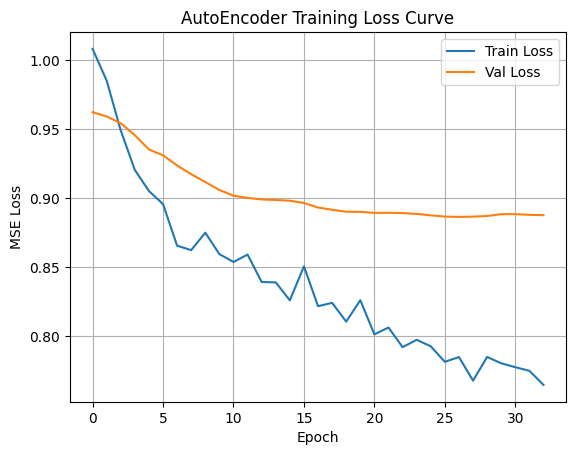

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("AutoEncoder Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# latent 추출
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent').output)
X_encoded = encoder.predict(X_tensor)

# 재구성 오차
X_reconstructed = autoencoder.predict(X_tensor)
recon_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)
df['recon_error'] = recon_error

2/2 [==============================] - 0s 6ms/step


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# 라벨 처리
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['group'])  # Stroke=1, Control=0

# 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score
)

# 분류 모델 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM (Linear)': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 결과 저장용 리스트
results = []

# 모델별 학습 및 평가
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'AUC': auc
    })

# DataFrame으로 정리
import pandas as pd
df_result = pd.DataFrame(results).round(3)
print("모델 성능 비교:")
display(df_result)

모델 성능 비교:


,Model,Accuracy,Sensitivity,Specificity,Precision,F1,AUC
0,Logistic Regression,0.846,0.75,1.0,1.0,0.857,0.875
1,SVM (Linear),0.846,0.75,1.0,1.0,0.857,0.850
2,Random Forest,0.846,0.75,1.0,1.0,0.857,0.950


In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 1. 준비
X = X_encoded  # AE latent (numpy 배열)
y = df['group'].values  # group (Stroke / Control)
idx = df.index  # 원본 인덱스 추적

# 2. 분할 (인덱스 포함)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, idx, test_size=0.2, stratify=y, random_state=42
)

# 3. 분류기 학습 (Logistic → RandomForest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# 4. FN 마스크: 실제 Stroke인데 Control로 예측한 경우
fn_mask = (y_test == 'Stroke') & (y_pred == 'Control')

# 5. FN 인덱스 → 원본 df에서 추출
fn_idx = idx_test[fn_mask]
fn_cases = df.loc[fn_idx]

# 6. 주요 열 확인
print("FN 케이스 요약:")
display(fn_cases[['sample', 'group', 'recon_error']].head())

# 7. 전체 FN 재구성오차 평균
mean_fn_error = fn_cases['recon_error'].mean()
mean_total_error = df['recon_error'].mean()

print(f"\n FN 평균 재구성 오류: {mean_fn_error:.4f}")
print(f" 전체 평균 오류 대비: {mean_fn_error / mean_total_error:.2f}배")

#  Latent representation은 분류에는 유의미하지만
# reconstruction error 기반 FN 검출엔 적절하지 않을 수 있음

FN 케이스 요약:


,sample,group,recon_error
21,3100137,Stroke,0.716468
24,3100193,Stroke,0.658748



 FN 평균 재구성 오류: 0.6876
 전체 평균 오류 대비: 0.90배


2/2 [==============================] - 0s 15ms/step


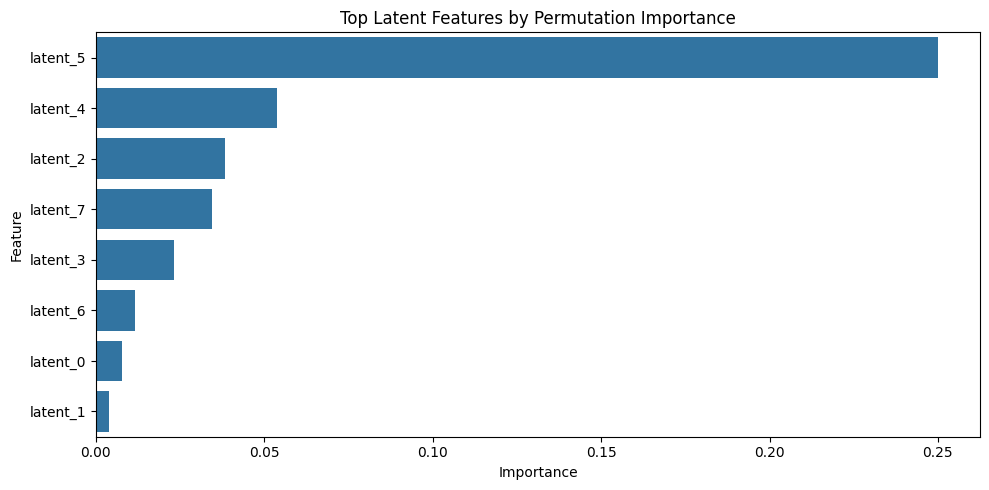

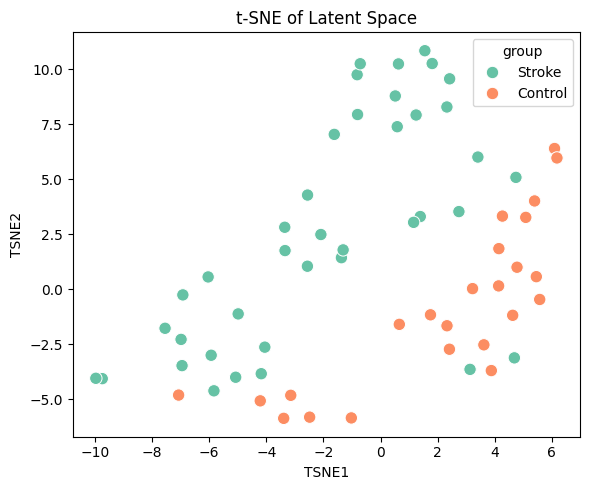

In [39]:
# Latent Feature 중요도 해석 + t-SNE 시각화
from tensorflow.keras.models import Model

# 기존 AE의 encoder 추출
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent').output)
X_encoded = encoder.predict(X_tensor)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import pandas as pd

# 라벨 추출
y = df['group'].values

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

# 모델 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Permutation Importance 계산
result = permutation_importance(clf, X_test, y_test, n_repeats=20, random_state=42)

# 시각화용 정리
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.DataFrame({
    'Feature': [f'latent_{i}' for i in range(X_encoded.shape[1])],
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title("Top Latent Features by Permutation Importance")
plt.tight_layout()
plt.show()

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'group': df['group'].values
})

plt.figure(figsize=(6, 5))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='group', s=80, palette='Set2')
plt.title("t-SNE of Latent Space")
plt.tight_layout()
plt.show()